*(Optional Notebook)*
# GPU Acceleration with CUDA
This notebook covers how GPU acceleration can be used using `CUDA.jl` and other supported packages. Currently, support accross various packages exists for:
* NVIDIA CUDA GPUs (`CUDA.jl`) -> Full support
* Intel GPU with oneAPI (`oneAPI.jl`) -> Largely supported
* AMD GPU running ROCm (`AMDGPU.jl`) -> Maturing support
* MacOS Metal (`Metal.jl`) -> Experimental support

As the most complete support exists for NVIDIA CUDA GPUs, they will be exploited in this notebook. Feel free to also experiment with the other types in case you own one of these machines. Installation of CUDA.jl is not included in the `Project.toml` file, so you will have to install it yourself. For this, you need to make sure you have [Visual C++ redistributable](https://aka.ms/vs/16/release/vc_redist.x64.exe) installed. Afterwards you can run

```
pkg> add CUDA
```

If this errors, this means that you have either not installed Visual C++, or do not have a fully compatible GPU on your machine. See [the CUDA.jl repository](https://github.com/JuliaGPU/CUDA.jl) for more information.

In [1]:
using CUDA

CUDA.functional()

true

We're not going to dive into the depths of developing GPU accelerated tools here. However, Flux already provides us with the functionality to run our models on the GPU. Let's run the MNIST example from the previous notebook on the GPU. First, we also need to install the `cuDNN` dependency using

```
pkg> add cuDNN
```

In [2]:
using Flux, CUDA, Statistics
using MLJ: partition
using Plots
using MLDatasets: MNIST

We can load the MNIST data in the same way as before.

In [3]:
data = MNIST(:train, dir="../datasets")
train_idx, test_idx = partition(1:length(data.targets), 0.8, rng=123);
train_ft = data.features[:,:,train_idx];
train_ft = reshape(train_ft, (size(train_ft, 1), size(train_ft, 2), 1, size(train_ft, 3)))
train_lb = data.targets[train_idx];

test_ft = data.features[:,:,test_idx];
test_ft = reshape(test_ft, (size(test_ft, 1), size(test_ft, 2), 1, size(test_ft, 3)))
test_lb = data.targets[test_idx];

Also the network definition is extremely similar. Note that now we have to move it to the GPU explicitly using `|> gpu`

In [4]:
# define the network
model = Chain(
  Conv((3,3), 1 => 12, relu),
  MaxPool((2,2)),
  Conv((3,3), 12 => 24, relu),
  MaxPool((2,2)),
  Conv((3,3), 24 => 48, relu),
  MaxPool((2,2)),
  Dropout(0.2),
  Flux.flatten,
  Dense(48 => 10)
) |> gpu

Chain(
  Conv((3, 3), 1 => 12, relu),          # 120 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 12 => 24, relu),         # 2_616 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 24 => 48, relu),         # 10_416 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Flux.flatten,
  Dense(48 => 10),                      # 490 parameters
)                   # Total: 8 arrays, 13_642 parameters, 2.211 KiB.

We also define the train and test datasets and move them to the gpu

In [5]:
train_targets = Flux.onehotbatch(train_lb, 0:9) |> gpu
test_targets = Flux.onehotbatch(test_lb, 0:9) |> gpu
train_sources = Flux.DataLoader((train_ft, train_targets), batchsize = 20_000, shuffle = true) |> gpu
test_sources = test_ft |> gpu

3-element DataLoader(::MLUtils.MappedData{:auto, typeof(gpu), Tuple{Array{Float32, 4}, OneHotArrays.OneHotMatrix{UInt32, CuArray{UInt32, 1, CUDA.Mem.DeviceBuffer}}}}, shuffle=true, batchsize=20000)
  with first element:
  (28×28×1×20000 CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, 10×20000 OneHotMatrix(::CuArray{UInt32, 1, CUDA.Mem.DeviceBuffer}) with eltype Bool,)

Create the model setup.

In [6]:
optim = Flux.setup(Flux.Adam(0.01), model);

And train the model, also using the same code as in the CPU notebook.

In [7]:
losses = []
val_losses = []

epochs = 100

for epoch in 1:epochs
  if epoch % 2 == 0
    println("Epoch $(epoch)\n\tLoss: $(losses[end])\n\tTest Loss: $(val_losses[end])\n")
  end
  epoch_loss = []
  for (x, y) in train_sources
    loss, grads = Flux.withgradient(model) do m
      ŷ = m(x)
      Flux.logitcrossentropy(ŷ, y)
    end
    Flux.update!(optim, model, grads[1])
    push!(epoch_loss, loss)
  end
  
  ŷ_val = model(test_sources)
  val_loss = Flux.logitcrossentropy(ŷ_val, test_targets)
  push!(losses, mean(epoch_loss))
  push!(val_losses, val_loss)
end

Epoch 2
	Loss: 2.226374
	Test Loss: 1.9417835



Epoch 4
	Loss: 1.2800721
	Test Loss: 0.8686232



Epoch 6
	Loss: 0.76998377
	Test Loss: 0.5230588



Epoch 8
	Loss: 0.5426827
	Test Loss: 0.3826766



Epoch 10
	Loss: 0.42339805
	Test Loss: 0.2985084



Epoch 12
	Loss: 0.3534493
	Test Loss: 0.24176005


Epoch 14
	Loss: 0.29005715
	Test Loss: 0.20697941



Epoch 16
	Loss: 0.25497267
	Test Loss: 0.1822903



Epoch 18
	Loss: 0.22622104
	Test Loss: 0.16321607



Epoch 20
	Loss: 0.20073527
	Test Loss: 0.14745827



Epoch 22
	Loss: 0.18571967
	Test Loss: 0.13561802


Epoch 24
	Loss: 0.16856389
	Test Loss: 0.1243654


Epoch 26
	Loss: 0.15698002
	Test Loss: 0.11485602



Epoch 28
	Loss: 0.14759852
	Test Loss: 0.110310994


Epoch 30
	Loss: 0.13793673
	Test Loss: 0.103703454



Epoch 32
	Loss: 0.13125257
	Test Loss: 0.09789522



Epoch 34
	Loss: 0.12096993
	Test Loss: 0.09385219



Epoch 36
	Loss: 0.120413326
	Test Loss: 0.09204144


Epoch 38
	Loss: 0.11558258
	Test Loss: 0.088958025



Epoch 40
	Loss: 0.108324625
	Test Loss: 0.08709422



Epoch 42
	Loss: 0.103097975
	Test Loss: 0.08466964



Epoch 44
	Loss: 0.10241002
	Test Loss: 0.081858955



Epoch 46
	Loss: 0.095700465
	Test Loss: 0.081699185



Epoch 48
	Loss: 0.09772014
	Test Loss: 0.077993415



Epoch 50
	Loss: 0.09087721
	Test Loss: 0.07794054



Epoch 52
	Loss: 0.09023255
	Test Loss: 0.07493113


Epoch 54
	Loss: 0.08047733
	Test Loss: 0.073430054


Epoch 56
	Loss: 0.08226455
	Test Loss: 0.07325263


Epoch 58
	Loss: 0.077352636
	Test Loss: 0.07376561


Epoch 60
	Loss: 0.07813064
	Test Loss: 0.0715932


Epoch 62
	Loss: 0.0768374
	Test Loss: 0.07107402


Epoch 64
	Loss: 0.07637355
	Test Loss: 0.07061512



Epoch 66
	Loss: 0.07432905
	Test Loss: 0.0748668



Epoch 68
	Loss: 0.074098706
	Test Loss: 0.06962779



Epoch 70
	Loss: 0.069244616
	Test Loss: 0.06913504


Epoch 72
	Loss: 0.06924857
	Test Loss: 0.068621



Epoch 74
	Loss: 0.067393765
	Test Loss: 0.06870679


Epoch 76
	Loss: 0.062388618
	Test Loss: 0.066899575


Epoch 78
	Loss: 0.06438336
	Test Loss: 0.066461995


Epoch 80
	Loss: 0.06465762
	Test Loss: 0.06536193



Epoch 82
	Loss: 0.058618825
	Test Loss: 0.06653944


Epoch 84
	Loss: 0.05947207
	Test Loss: 0.06442124


Epoch 86
	Loss: 0.060689423
	Test Loss: 0.06249106


Epoch 88
	Loss: 0.057394955
	Test Loss: 0.06351351



Epoch 90
	Loss: 0.054771155
	Test Loss: 0.06436638


Epoch 92
	Loss: 0.055859625
	Test Loss: 0.06510945



Epoch 94
	Loss: 0.057038173
	Test Loss: 0.06571017



Epoch 96
	Loss: 0.05298789
	Test Loss: 0.06303719


Epoch 98
	Loss: 0.05347045
	Test Loss: 0.06262618



Epoch 100
	Loss: 0.051443
	Test Loss: 0.06724119



We can then visualize our 100 epochs using an animation:

┌ Info: Saved animation to d:\Julia-sysbio-workshop\figures\losscurve.gif
└ @ Plots C:\Users\20169366\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("d:\\Julia-sysbio-workshop\\figures\\losscurve.gif")
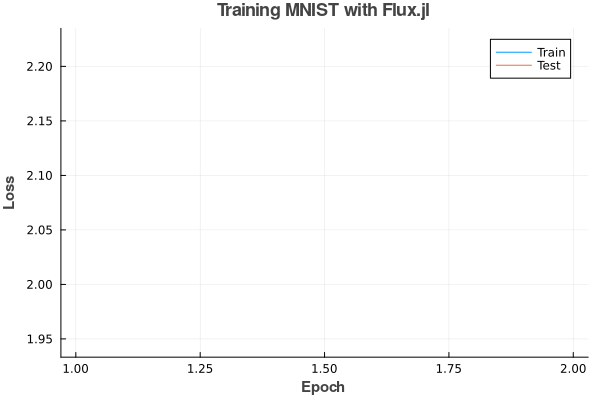

In [13]:
anim = @animate for epoch in 1:epochs
  pl = plot(losses[1:epoch], xlabel="Epoch", ylabel="Loss", title="Training MNIST with Flux.jl",
  titlefontfamily="Helvetica Bold", titlefontsize=12, guidefontfamily="Helvetica Bold", guidefontsize=10,
  label="Train")
  plot!(val_losses[1:epoch], label="Test")
end

gif(anim, "../figures/losscurve.gif", fps=20)

---
Exercise
---

The `MLDatasets` library also contains other datasets. An example is the `SVHN2`-dataset, containing Google street view housing numbers. See [the documentation](https://juliaml.github.io/MLDatasets.jl/stable/datasets/vision/#MLDatasets.SVHN2) for more information and how to use it. 

Train a neural network on this dataset that predicts the housing number from the image and visualize the training process using an animation.

In [ ]:
# Ready? Set? GPU!

---